# count-based word embedding

## word-context matrix (co-occurrence matrix)

**word-context matrix** $M \in \mathbb{R}^{|V_W|\times |V_C|}$

- rows: unique words in word vocabulary $V_W$

- columns: unique context words in context vocabulary $V_C$

word vocab vs context vocab

- $|V_W|= |V_C|$, word-context matrix is square: 

    most cases, including Word2Vec, GloVe, and other algorithms that use a sliding window to define context.


- $|V_W|\neq |V_C|$, word-context matrix is rectangular:

    - Reducing dimensionality: selecting most frequent words as context words. matrix has more rows than columns.

    - additional linguistic features: e.g. POS tags, named entity tags. matrix has fewer rows than columns.

    - higher-level context: e.g., context vocab of LDA consists of topics rather than individual words. matrix has more rows than columns.

| Word-Context Matrix | Formula | Short Description | Pros | Cons |
|---------------------|---------|-------------------|------|------|
| co-occurrence Matrix     | $\#(w,c)$     | Raw co-occurrence count | Simple, easy to compute | Sparse, sensitive to frequent words |
| PMI                 | $\log_2 \frac{P(w,c)}{P(w)P(c)}$ | Log ratio of joint probability to marginal probabilities | Captures word associations, less sensitive to frequent words | Negative infinity for unobserved pairs doesn't provide any meaningful information about them and lead to numerical instability. sensitive to rare words |
| SPMI  (Shifted PMI)              | $\log_2 \frac{P(w,c)}{P(w)P(c)} - \log k$ | GloVe, $k$ is the number of negative samples | Balances positive and negative associations | sensitive to rare words |
| PPMI  (Positive PMI)              | $\max \left(0, \log_2 \frac{P(w,c)}{P(w)P(c)}\right)$ | sets negative PMI values to 0 | Addresses negative infinity issue, less sensitive to rare words | Loses information about negative associations |
| SPPMI  (Shifted Positive PMI)             | $\max \left(0, \log_2 \frac{P(w,c)}{P(w)P(c)}\right) - \log k$ | sets negative PMI values to 0 and negative sampling $k$ examples | Combines advantages of PPMI and SPMI | Can still be sensitive to rare words |


entry $M_{i, j}$: word-context co-occurrence count (correlation measure between the word $w_i$ and the context $w_j$)

- standard: raw co-occurrence count, frequency of target word $w_i$ occur with context word $w_j$ together

- variants: weighted co-occurrence count. PMI, SPMI, PPMI, SPPMI

    give more weight to rare word co-occurrences, reduce the influence of noise or spurious co-occurrences. info-theory measure by different weighting schemes:

    PMI (pointwise mutual info matrix): log ratio of joint probability to marginal probabilities. 
    
    $$
    \text{PMI}(w,c) = \log_2 \frac{P(w,c)}{P(w)P(c)}= \log_2 \left [\frac{\frac{\#(w,c)}{|D|}}{\frac{\#(w)}{|D|}\frac{\#(c)}{|D|}}  \right ]= \log_2 \left [\frac{\#(w,c)\cdot |D|}{\#(w) \cdot \#(c)}  \right ]
    $$

    $\#(w,c)$ is the number of times the specific word-context pair $(w,c)$ occurs in corpus $D$

    total number of word-context paris in corpus $|D|= \sum_{w \in V_W}\sum_{c \in V_C} \#(w,c)$

    $\#(w) = \sum_{c' \in V_C} \#(w,c')$ is the number of times the specific word $w$ occurs in $D$

    $\#(c) = \sum_{w' \in V_W} \#(w',c)$ is the number of times the specific context $c$ occurs in $D$

- Intuition of PPMI discarding negative value: 

    humans can easily think of positive examples of positive association (e.g. Micky and Mouse) 

    but hard to invent negative examples of negative association (e.g., Micky and turkey). 

## algorithm: SVD

### truncated SVD

truncated SVD is a basic algorithm from linear algebra to achieve optimal **rank d** factorization with respect to $l_2$ loss

SVD factorize $M \in \mathbb{R}^{|\mathcal{V}| \times |\mathcal{V}|}$ into product of 3 matrices

$$
M=US V^T
$$

where $U \in \mathbb{R}^{|\mathcal{V}| \times |\mathcal{V}|}$ is an orthonormal matrix with columns are the left singular vectors of $M$

$S \in \mathbb{R}^{|\mathcal{V}| \times |\mathcal{V}|}$ is a diagonal matrix with diagonal entries of singular values of $M$

$V \in \mathbb{R}^{|\mathcal{V}| \times |\mathcal{V}|}$ is an orthonormal matrix with columns are the right singular vectors of $M$

recall 4th interpretation of PCA: low-rank (k) matrix approximation 

training goal: optimize over **rank d** matrix $M'$ to minimize $l_2$ reconstruction error

$$
\hat M' = \underset{\text{Rank}(M')=d}{\arg \min}=\left \| M'-M \right \|_2^2
$$

the optimal solution is the rank d matrix $M_d \in \mathbb{R}^{|\mathcal{V}| \times |\mathcal{V}|}$ that best approximate the original matrix $M$

$$
\hat M' =M_d=U_dS_d V_d^T
$$

where $U_d  \in \mathbb{R}^{|\mathcal{V}| \times d}$ is an orthonormal matrix with columns are the **top d** left singular vectors of $M$

$S_d \in \mathbb{R}^{d \times d}$ is a diagonal matrix with **top d** diagonal entries of singular values of $M$

$V_d \in \mathbb{R}^{|\mathcal{V}| \times d}$ is an orthonormal matrix with columns are the **top d** right singular vectors of $M$

thus, given $|\mathcal{V}| \gg d$, the dense, d dimensional rows of $W=U_d S_d$ is a perfect substitues for the very high-dimensional ($|\mathcal{V}|$) rows of $M$

$$
W^{SVD}=U_d S_d \in \mathbb{R}^{|\mathcal{V}| \times |\mathcal{V}|}\\[1em]
C^{SVD}=V_d \in \mathbb{R}^{|\mathcal{V}| \times |\mathcal{V}|}
$$


- word embedding $\mathbf{w}_i \in \mathbb{R}^{d}$:

$$
\mathbf{w}_i = [U_d S_d]_i = W_i
$$

- context embedding $\mathbf{c}_i \in \mathbb{R}^{d}$:

$$
\mathbf{c}_i = [V_d]_i = C_i
$$



### symmetric SVD

- word embedding matrix $W^{SVD}$ and context embedding matrix $C^{SVD}$ have different properties:

    $W^{SVD}$ is not orthonormal, $C^{SVD}$ is orthonormal


- while factorization achieved by SGNS is more **symmetric**

    neither $W^{W2V}$ nor $C^{W2V}$ is orthonormal

    and no bias is given to either matrics in training objective


- thus we propose another SVD algorithm: symmetric SVD

$$
W^{SVD_{1/2}}=U_d {S_d}^{1/2}\\[1em]
C^{SVD_{1/2}}=V_d {S_d}^{1/2}
$$

- this algorithm perform better than previous SVD algorithm

- this algorithm can be generalized to, making $\alpha$ a tunable parameter

$$
W^{SVD_{\alpha}}=U_d {S_d}^{\alpha}\\[1em]
C^{SVD_{\alpha}}=V_d {S_d}^{\alpha}
$$

## example using vanilla co-occurrence matrix with bigram context

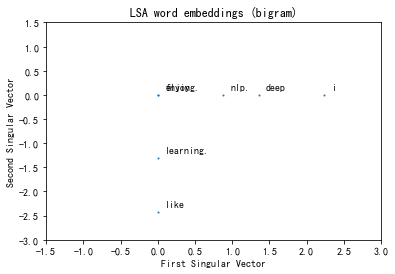

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Example corpus
corpus = "I like deep learning. I like NLP. I enjoy flying."

# Preprocessing
words = [word.lower() for word in corpus.split()]
unique_words = list(set(words))
vocab_size = len(unique_words)

# Create the co-occurrence matrix with bigram context
co_occurrence_matrix = np.zeros((vocab_size, vocab_size))
for i in range(vocab_size - 1):
    target_word = words[i]
    context_word = words[i + 1]
    co_occurrence_matrix[unique_words.index(target_word), unique_words.index(context_word)] += 1
    co_occurrence_matrix[unique_words.index(context_word), unique_words.index(target_word)] += 1

# Singular Value Decomposition (SVD) of co_occurrence_matrix
U, s, Vt = np.linalg.svd(co_occurrence_matrix)

# Select the top k singular values
k = 2
S_k = np.diag(s[:k])

# Compute word embeddings using the matrix product U * S_k
word_embeddings = U[:, :k] @ S_k

# Visualize words in 2D
plt.scatter(word_embeddings[:, 0], word_embeddings[:, 1], s=1)

for i, word in enumerate(unique_words):
    plt.text(word_embeddings[i, 0]+0.1, word_embeddings[i, 1]+0.1, word)

plt.xlim(-1.5, 3)
plt.ylim(-3, 1.5)
plt.xlabel('First Singular Vector')
plt.ylabel('Second Singular Vector')
plt.title('LSA word embeddings (bigram)')
plt.show()
